In [32]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
tfd = tfp.distributions

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten

Num GPUs Available:  1


In [33]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [34]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

In [35]:
# filter & duplicate drop from bayesian_nn
z_max = 1
filt = (photozdata['specz_redshift'] < z_max)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 100)\
&(photozdata['r_cmodel_mag'] < 100)\
&(photozdata['i_cmodel_mag'] < 100)\
&(photozdata['z_cmodel_mag'] < 100)\
&(photozdata['y_cmodel_mag'] < 100)\
&(photozdata['specz_flag_homogeneous'] == True)
photozdata.drop_duplicates(subset=['object_id'])
photozdata_subset = np.asarray(photozdata[filt])

In [36]:
photozdata.columns

Index(['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'],
      dtype='object')

In [37]:
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
# shuffle the data

In [38]:
n = len(photozdata_subset)

In [39]:
X_total = photozdata_subset[:,[12,13,14,15,16]]
y_total = photozdata_subset[:,2]

In [40]:
X_total = preprocessing.normalize(X_total)

In [41]:
count = 11 # number of networks, including the BNN

In [42]:
# split data into 6/7 bins of training sets of 40000 and 1 bin of testing set of 6401
X = []
y = []

bin_size = 20000

pre = 0
per = bin_size - 1

for i in range(0,count):
    X.append(np.asarray(X_total[pre:per + 1]).astype('float32'))
    y.append(np.asarray(y_total[pre:per + 1]).astype('float32'))
    pre = pre + bin_size
    per = per + bin_size

X_test = np.asarray(X_total[pre : pre + 500]).astype('float32')
y_test = np.asarray(y_total[pre : pre + 500]).astype('float32')

# X_pre = np.asarray(X_total[0 : pre]).astype('float32')
# y_pre = np.asarray(y_total[0 : pre]).astype('float32')

In [43]:
models = []

for i in range(1,count):
    input_ = tf.keras.layers.Input(shape=X[0].shape[1:])
    hidden1 = tf.keras.layers.Dense(200, activation="tanh")(input_)
    hidden2 = tf.keras.layers.Dense(200, activation="tanh")(hidden1)
    hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
    hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
    # hidden5 = tf.keras.layers.Dense(200, activation="relu")(hidden4)
    # hidden6 = tf.keras.layers.Dense(200, activation="relu")(hidden5)
    concat = tf.keras.layers.Concatenate()([input_, hidden4])
    output = tf.keras.layers.Dense(1)(concat)
    model = tf.keras.Model(inputs=[input_], outputs=[output])
    model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])
    models.append(model)

input_ = tf.keras.layers.Input(shape=X[0].shape[1:])
hidden1 = tf.keras.layers.Dense(200, activation="relu")(input_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
hidden5 = tf.keras.layers.Dense(200, activation="relu")(hidden4)
hidden6 = tf.keras.layers.Dense(200, activation="relu")(hidden5)
concat = tf.keras.layers.Concatenate()([input_, hidden6])
output = tf.keras.layers.Dense(1)(concat)
model_pre = tf.keras.Model(inputs=[input_], outputs=[output])
model_pre.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

model_pre.fit(X_pre,y_pre,epochs=50,shuffle = True,verbose=1)

In [44]:
for i in range(0,count - 1):
    models[i].fit(X[i],y[i],epochs=25,shuffle = True,verbose=1)

Epoch 1/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0341 - mean_absolute_error: 0.1524
Epoch 2/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0230 - mean_absolute_error: 0.1157
Epoch 3/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0210 - mean_absolute_error: 0.1083
Epoch 4/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0204 - mean_absolute_error: 0.1050
Epoch 5/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0187 - mean_absolute_error: 0.0971
Epoch 6/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0190 - mean_absolute_error: 0.0998
Epoch 7/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0181 - mean_absolute_error: 0.0954
Epoch 8/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.0881
Epoch 9/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.0906
E

625/625 [==============================] - 1s 1ms/step - loss: 0.0166 - mean_absolute_error: 0.0862
Epoch 25/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0167 - mean_absolute_error: 0.0873
Epoch 1/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0374 - mean_absolute_error: 0.1591
Epoch 2/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0204 - mean_absolute_error: 0.1021
Epoch 3/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0201 - mean_absolute_error: 0.1008
Epoch 4/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0192 - mean_absolute_error: 0.0970
Epoch 5/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0184 - mean_absolute_error: 0.0936
Epoch 6/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0184 - mean_absolute_error: 0.0935
Epoch 7/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0184 - mean_absolute_error: 0.0937
Epoch 8/25


625/625 [==============================] - 1s 1ms/step - loss: 0.0174 - mean_absolute_error: 0.0881
Epoch 23/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0180 - mean_absolute_error: 0.0903
Epoch 24/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0175 - mean_absolute_error: 0.0882
Epoch 25/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0171 - mean_absolute_error: 0.0864
Epoch 1/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0345 - mean_absolute_error: 0.1483
Epoch 2/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0231 - mean_absolute_error: 0.1107
Epoch 3/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0217 - mean_absolute_error: 0.1046
Epoch 4/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0202 - mean_absolute_error: 0.0985
Epoch 5/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0209 - mean_absolute_error: 0.1013
Epoch 6/2

625/625 [==============================] - 1s 1ms/step - loss: 0.0188 - mean_absolute_error: 0.0913
Epoch 21/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0195 - mean_absolute_error: 0.0944
Epoch 22/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0191 - mean_absolute_error: 0.0933
Epoch 23/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0192 - mean_absolute_error: 0.0935
Epoch 24/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0197 - mean_absolute_error: 0.0954
Epoch 25/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0194 - mean_absolute_error: 0.0944
Epoch 1/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0362 - mean_absolute_error: 0.1528
Epoch 2/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0230 - mean_absolute_error: 0.1086
Epoch 3/25
625/625 [==============================] - 1s 1ms/step - loss: 0.0216 - mean_absolute_error: 0.1023
Epoch 4

y_predict_pre = []
for i in range(0,len(X_test)):
        predicted = model_pre.predict(np.array([X_test[i]]))
        y_predict_pre.append(float(predicted))

In [45]:
y_predict = []

for i in range(0,count - 1):
    y_predict_single = []
    for j in range(0,len(X_test)):
        clear_output(wait=True)
        print(str(i) + ' ' + str(j))
        predicted = models[i].predict(np.array([X_test[j]]))
        y_predict_single.append(float(predicted))
    y_predict.append(y_predict_single)

clear_output(wait=True)
y_predict = np.transpose(y_predict)

9 499


In [46]:
mean_array = []
std_array = []
for i in range(0,len(X_test)):
    mean = np.mean(y_predict[i])
    std = np.std(y_predict[i])
    mean_array.append(mean)
    std_array.append(std)

In [47]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,mean_array])
z = gaussian_kde(xy)(xy)

xy_pre = np.vstack([y_test,y_predict_pre])
z_pre = gaussian_kde(xy_pre)(xy_pre)

fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, y_predict_pre, c = z_pre, s = 1, edgecolor = None)
plt.colorbar(scatter_plot)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 1], [0, 1],color = 'black')

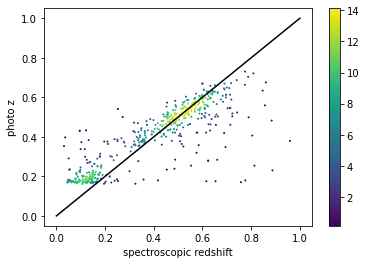

In [48]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, mean_array, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')

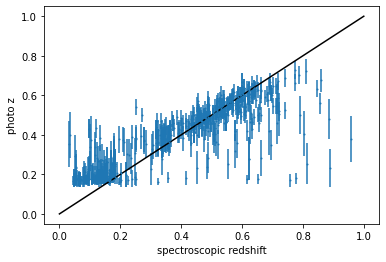

In [49]:
fig, ax = plt.subplots()
error_plot = ax.errorbar(y_test, mean_array, yerr = std_array, fmt="o" ,markersize=1)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')

In [50]:
overlap = 0
overlap_array = []
for i in range(0,len(X_test)):
    if np.abs(y_test[i]-mean_array[i])<=std_array[i]:
        overlap += 1
        overlap_array.append(1)
    else:
        overlap_array.append(0)
print(overlap/len(X_test))

0.426


In [51]:
combined_array = np.transpose(np.vstack((y_test,mean_array,std_array,overlap_array)))

In [52]:
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])

In [53]:
bins = int(z_max*10)
splitted_sorted_combined_array = np.array_split(sorted_combined_array,bins)
coverage = []
for i in range(0,bins):
    bins_count = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        if splitted_sorted_combined_array[i][j][3] == 1:
            bins_count += 1
    coverage.append(bins_count/len(splitted_sorted_combined_array[i])/0.6827)
x_array = np.arange(0,z_max,z_max/bins)

(0.0, 1.5)

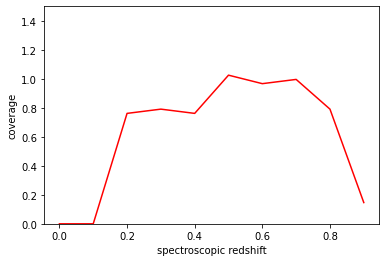

In [54]:
plt.plot(x_array, coverage, c = 'red')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0,1.5]) # 1.5 indicates full coverage

In [55]:
# from Evan's code, didn't completely understand this part
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [56]:
input_variational = tf.keras.layers.Input(shape=X[count - 1].shape[1:])
hidden1_variational = tfp.layers.DenseVariational(200, activation='tanh', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(input_variational)
hidden2_variational = tfp.layers.DenseVariational(200, activation='tanh', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden1_variational)
hidden3_variational = tfp.layers.DenseVariational(200, activation='relu', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden2_variational)
hidden4_variational = tfp.layers.DenseVariational(200, activation='relu', input_shape=(5,),
                                      make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y[count - 1]))(hidden3_variational)   

concat_variational = tf.keras.layers.Concatenate()([input_variational, hidden4_variational])

distribution_params_variational = tf.keras.layers.Dense(units=2)(concat_variational)

output_variational = tfp.layers.IndependentNormal(1)(distribution_params_variational)

model_variational = tf.keras.Model(inputs=[input_variational], outputs=[output_variational])

model_variational.compile(optimizer='adam', loss=negative_loglikelihood,metrics=[keras.metrics.RootMeanSquaredError()])

In [57]:
model_variational.fit(X[count - 1],y[count - 1],epochs=75,shuffle = True,verbose=1)

Epoch 1/75
625/625 [==============================] - 4s 3ms/step - loss: 52.3123 - root_mean_squared_error: 0.3203
Epoch 2/75
625/625 [==============================] - 2s 3ms/step - loss: 48.6855 - root_mean_squared_error: 0.2960
Epoch 3/75
625/625 [==============================] - 2s 3ms/step - loss: 45.4637 - root_mean_squared_error: 0.2902
Epoch 4/75
625/625 [==============================] - 2s 3ms/step - loss: 42.4938 - root_mean_squared_error: 0.2877
Epoch 5/75
625/625 [==============================] - 2s 3ms/step - loss: 39.9422 - root_mean_squared_error: 0.2824
Epoch 6/75
625/625 [==============================] - 2s 3ms/step - loss: 37.8480 - root_mean_squared_error: 0.2725
Epoch 7/75
625/625 [==============================] - 2s 3ms/step - loss: 36.1143 - root_mean_squared_error: 0.2645
Epoch 8/75
625/625 [==============================] - 2s 3ms/step - loss: 34.6499 - root_mean_squared_error: 0.2588
Epoch 9/75
625/625 [==============================] - 2s 3ms/step - loss

625/625 [==============================] - 2s 3ms/step - loss: 16.9420 - root_mean_squared_error: 0.2082
Epoch 72/75
625/625 [==============================] - 2s 3ms/step - loss: 16.8898 - root_mean_squared_error: 0.2082
Epoch 73/75
625/625 [==============================] - 2s 3ms/step - loss: 16.7314 - root_mean_squared_error: 0.2080
Epoch 74/75
625/625 [==============================] - 2s 3ms/step - loss: 16.7233 - root_mean_squared_error: 0.2079
Epoch 75/75
625/625 [==============================] - 2s 3ms/step - loss: 16.5974 - root_mean_squared_error: 0.2079


In [58]:
y_predict_variational = model_variational(X_test)

In [59]:
y_predict_variational_mean = np.asarray(y_predict_variational.mean())[:,0]

In [60]:
y_predict_variational_std = np.asarray(y_predict_variational.stddev())[:,0]

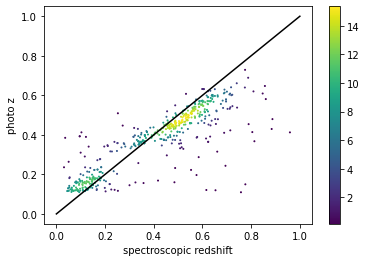

In [61]:
xy_variational = np.vstack([y_test,y_predict_variational_mean])
z_variational = gaussian_kde(xy_variational)(xy_variational)
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, y_predict_variational_mean, c = z_variational, s = 1, edgecolor = None)
plt.colorbar(scatter_plot)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')

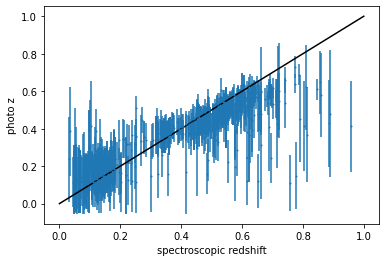

In [62]:
fig, ax = plt.subplots()
error_plot = ax.errorbar(y_test, y_predict_variational_mean, yerr = y_predict_variational_std, fmt="o", markersize=1)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, z_max], [0, z_max],color = 'black')

In [63]:
overlap_variational = 0
overlap_array_variational = []
for i in range(0,len(X_test)):
    if np.abs(y_test[i]-y_predict_variational_mean[i])<=y_predict_variational_std[i]:
        overlap_variational += 1
        overlap_array_variational.append(1)
    else:
        overlap_array_variational.append(0)
print(overlap_variational/len(X_test))

0.748


In [64]:
combined_array_variational = np.transpose(np.vstack((y_test,y_predict_variational_mean,y_predict_variational_std,overlap_array_variational)))

In [65]:
sorted_combined_array_variational = sorted(combined_array_variational, key=lambda x: x[0])

In [66]:
bins_variational = int(z_max*10)
splitted_sorted_combined_array_variational = np.array_split(sorted_combined_array_variational,bins)
coverage_variational = []
for i in range(0,bins_variational):
    bins_count_variational = 0
    for j in range(0,len(splitted_sorted_combined_array_variational[i])):
        if splitted_sorted_combined_array_variational[i][j][3] == 1:
            bins_count_variational += 1
    coverage_variational.append(bins_count_variational/len(splitted_sorted_combined_array_variational[i])/0.6827)
x_array = np.arange(0,z_max,z_max/bins_variational)

(0.0, 1.5)

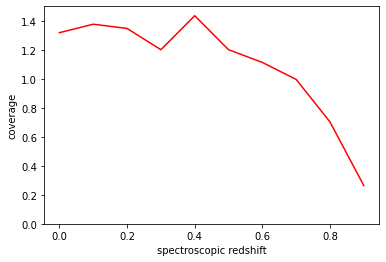

In [67]:
plt.plot(x_array, coverage_variational, c = 'red')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0,1.5]) # 1.5 indicates full coverage